In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
energy_hourly = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [6]:
energy_hourly.head(25) # 시간당 에너지 소비량

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


In [10]:
energy_hourly.sort_index(inplace=True)
energy_hourly.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


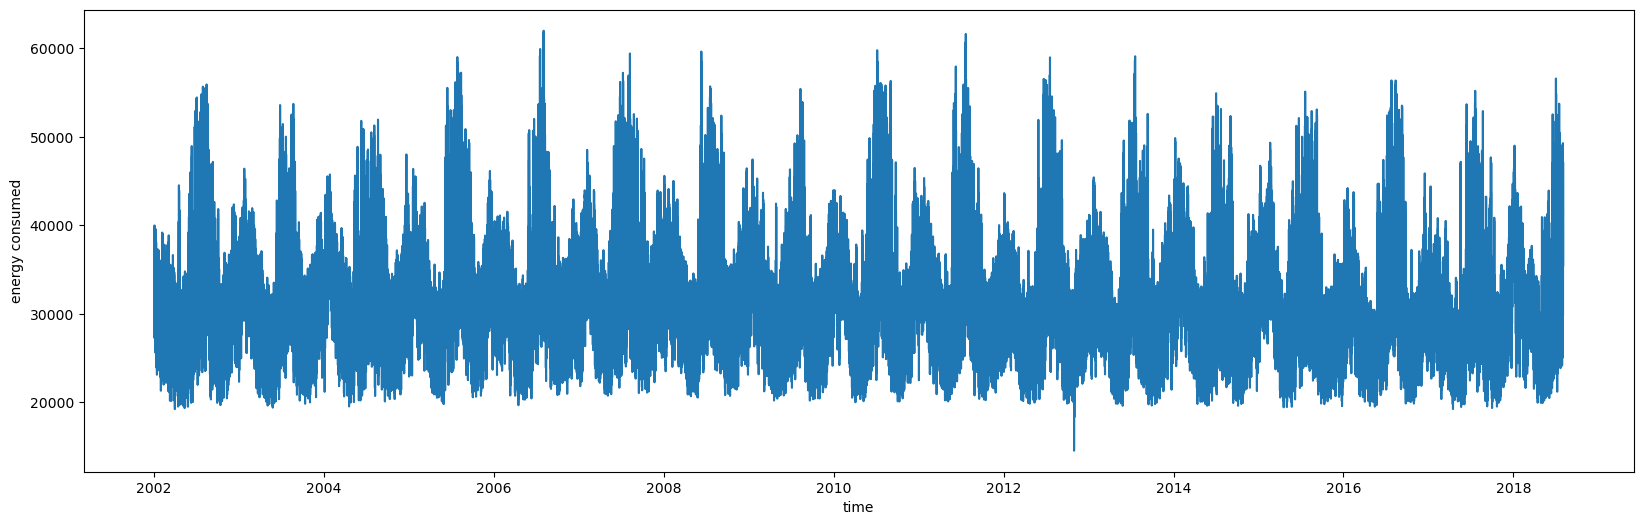

In [12]:
plt.figure(figsize=(20,6))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(energy_hourly)
plt.show()

In [13]:
def split_data(data, split_date):
    return data[data.index < split_date].copy(), data[data.index >= split_date].copy()

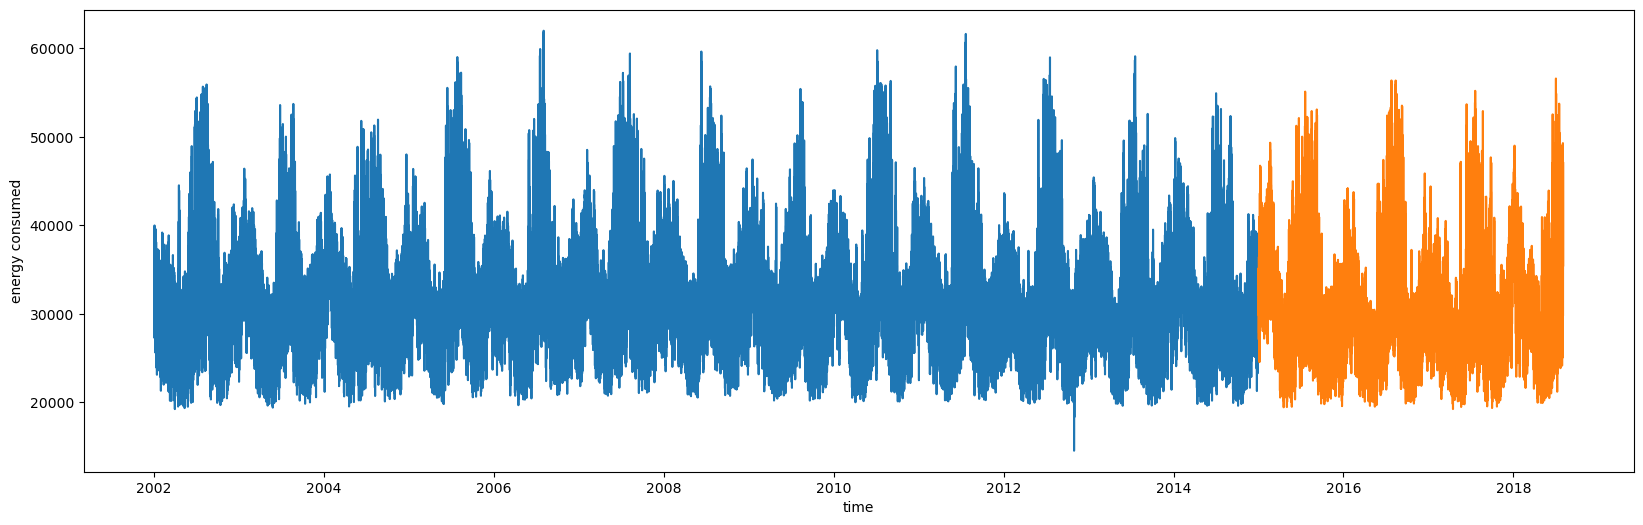

In [15]:
train, test = split_data(energy_hourly, '01-Jan-2015')

plt.figure(figsize=(20, 6))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(train)
plt.plot(test)
plt.show()

In [31]:
def create_feature(df): # 데이터 확장
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
    return X

In [32]:
X_train, y_train = create_feature(train), train['PJME_MW']
X_test, y_test = create_feature(test), test['PJME_MW']

In [33]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-01-01 01:00:00,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,5,1,1,1,2002,1,1,1


In [34]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(113926, 8) (113926,)
(31440, 8) (31440,)


In [39]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [41]:
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

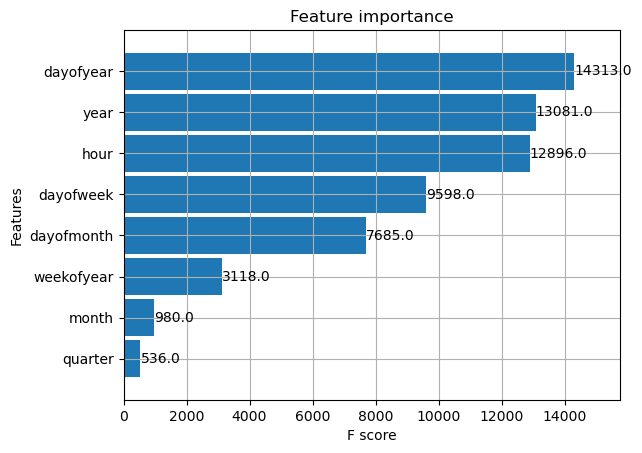

In [44]:
xgb.plot_importance(reg, height=0.9) # 중요도(의존도) 파악

In [50]:
# 실질적인 예측
def plot_performance(date_from, date_to, title=None):
    date_from = pd.to_datetime(date_from, format='%d-%m-%Y')
    date_to = pd.to_datetime(date_to, format='%d-%m-%Y')

    plt.figure(figsize=(15, 5))

    if title == None:
        plt.title('From {} To {}'.format(date_from, date_to))
    else:
        plt.title(title)

    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(energy_hourly.index, energy_hourly, label='data')
    plt.plot(X_test.index, X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

In [51]:
X_test_pred = reg.predict(X_test)

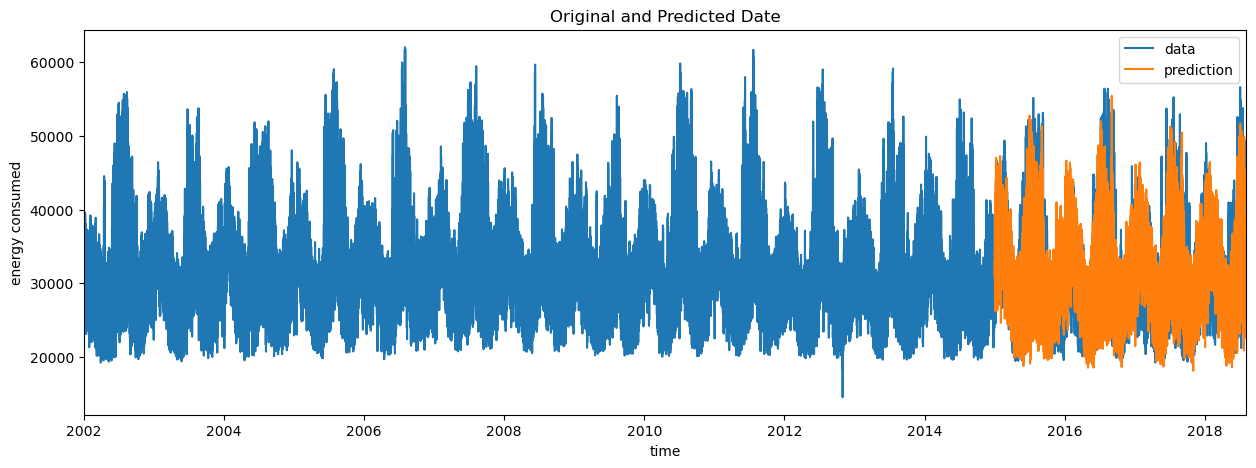

In [55]:
plot_performance(energy_hourly.index[0].date(), energy_hourly.index[-1].date(), 'Original and Predicted Date')

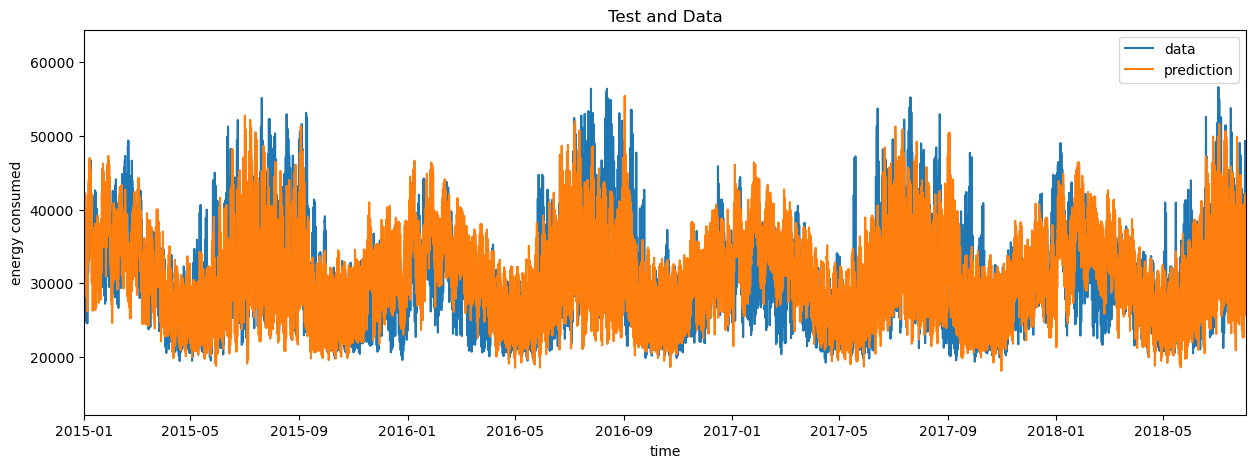

In [56]:
plot_performance(y_test.index[0].date(), y_test.index[-1].date(), 'Test and Data')

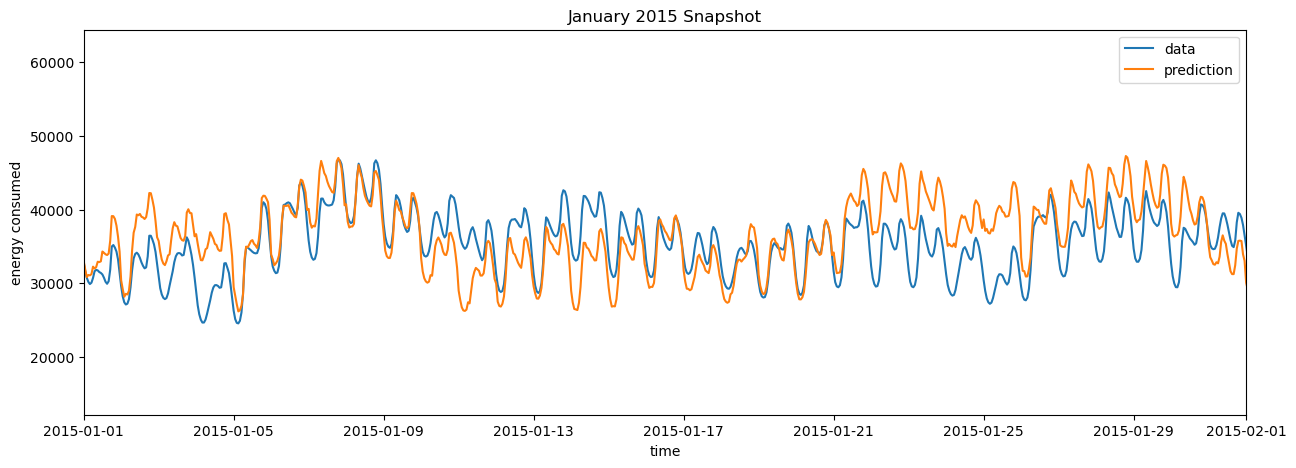

In [57]:
plot_performance('01-01-2015', '01-02-2015', 'January 2015 Snapshot')

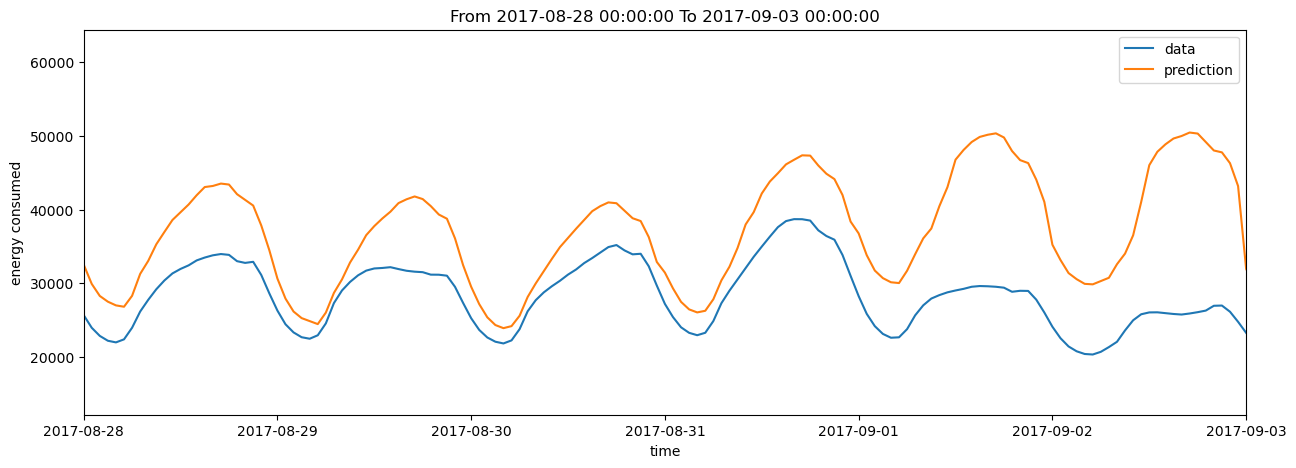

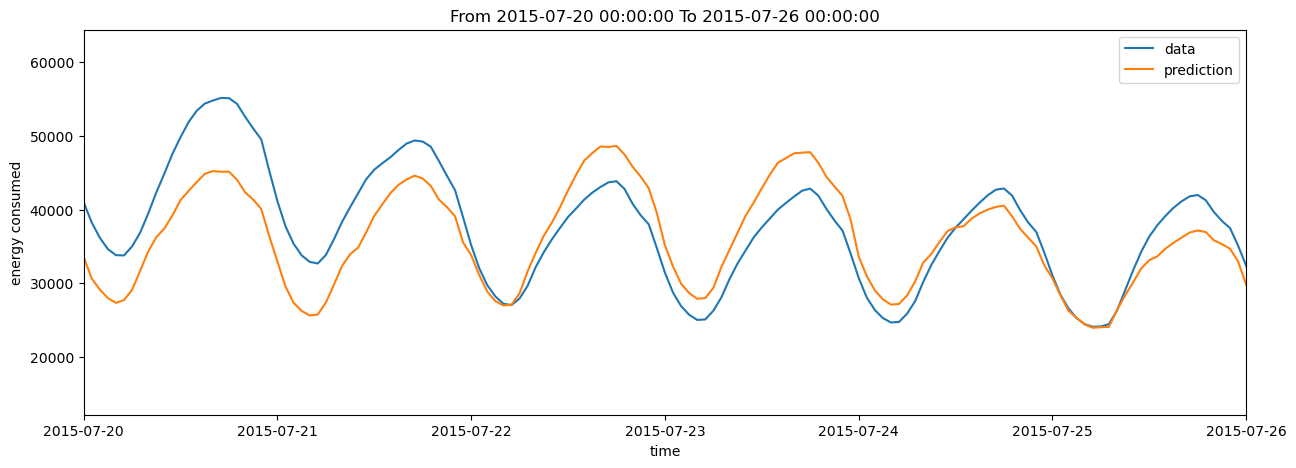

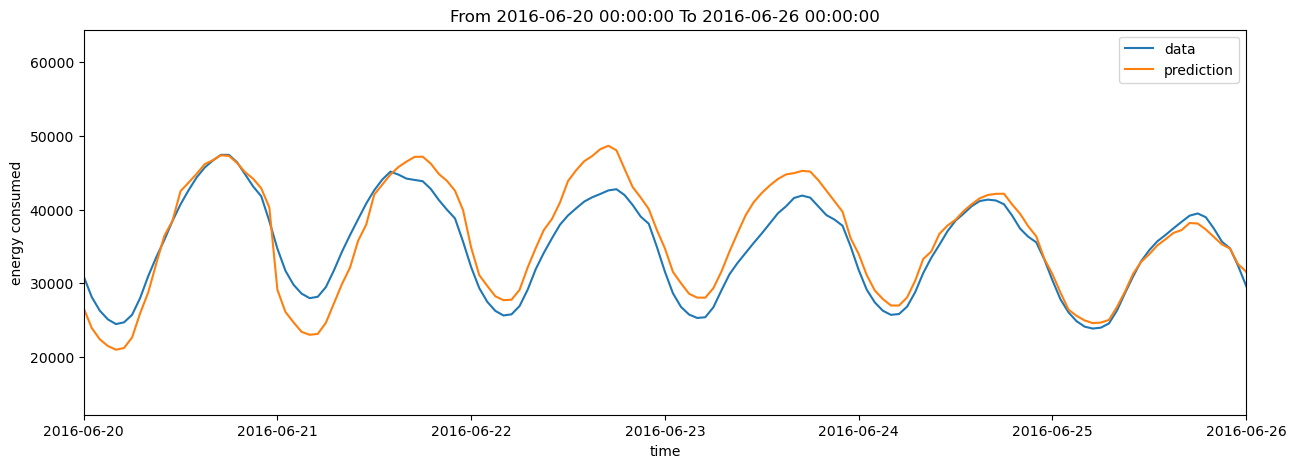

In [60]:
random_weeks = X_test[['year', 'weekofyear']].sample(3)

for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & (X_test.weekofyear == week[1].weekofyear)
    data = y_test[index]

    plot_performance(data.index[0].date(), data.index[-1].date())

In [61]:
# MSE, MAE 출력
mean_squared_error(y_true=y_test, y_pred=X_test_pred)

19360258.20029839

In [62]:
mean_absolute_error(y_true=y_test, y_pred=X_test_pred)

3291.0112801665873

In [64]:
X_test['PJME_MW'] = y_test
X_test['MW_Prediction'] = X_test_pred
X_test['error'] = y_test - X_test_pred
X_test['abs_error'] = X_test['error'].apply(np.abs)

error_by_day = X_test.groupby(['year', 'month', 'dayofmonth']).mean()[['PJME_MW', 'MW_Prediction', 'error', 'abs_error']]

error_by_day.head()

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 1     1           31765.583333   33987.273438 -2221.690511  2221.690511
           2           32141.166667   36171.675781 -4030.507161  4030.507161
           3           32014.375000   36261.269531 -4246.895264  4246.895264
           4           28542.291667   35659.167969 -7116.874512  7116.874512
           5           33176.125000   34492.617188 -1316.491618  1331.515869

In [65]:
error_by_day.sort_values('abs_error', ascending=True).head()

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 5     6           24058.083333   23975.843750   82.240234  194.948405
2016 10    16          23876.583333   23717.111328  159.470133  253.260498
     5     5           27239.875000   27216.781250   23.093180  278.467041
2015 10    24          24779.416667   24536.156250  243.260010  280.482015
2016 5     22          23595.416667   23638.068359  -42.650879  301.453451